In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/content/raw_house_data.csv')

#Check data is loaded

In [3]:
print(data.head())

        MLS  sold_price  zipcode   longitude   latitude  lot_acres     taxes  \
0  21530491   5300000.0    85637 -110.378200  31.356362    2154.00   5272.00   
1  21529082   4200000.0    85646 -111.045371  31.594213    1707.00  10422.36   
2   3054672   4200000.0    85646 -111.040707  31.594844    1707.00  10482.00   
3  21919321   4500000.0    85646 -111.035925  31.645878     636.67   8418.58   
4  21306357   3411450.0    85750 -110.813768  32.285162       3.21  15393.00   

   year_built  bedrooms bathrooms sqrt_ft garage  \
0        1941        13        10   10500      0   
1        1997         2         2    7300      0   
2        1997         2         3    None   None   
3        1930         7         5    9019      4   
4        1995         4         6    6396      3   

                                    kitchen_features  fireplaces  \
0            Dishwasher, Freezer, Refrigerator, Oven         6.0   
1                       Dishwasher, Garbage Disposal         5.0   
2 

In [4]:
print(data.shape)

(5000, 16)


#Check missing values

In [5]:
# Check for missing values
missing_values = data.isnull().sum()

In [6]:
# Print the number of missing values for each column
print(missing_values)

MLS                  0
sold_price           0
zipcode              0
longitude            0
latitude             0
lot_acres           10
taxes                0
year_built           0
bedrooms             0
bathrooms            0
sqrt_ft              0
garage               0
kitchen_features     0
fireplaces          25
floor_covering       0
HOA                  0
dtype: int64


#Fill missing values

In [7]:
# Fill in missing values in lot_acres with the median
median_lot_acres = data['lot_acres'].median()
data['lot_acres'].fillna(median_lot_acres, inplace=True)

In [8]:
# Fill in missing values in fireplaces with the mode
mode_fireplaces = data['fireplaces'].mode()[0]
data['fireplaces'].fillna(mode_fireplaces, inplace=True)

#Verify missing values are filled

In [9]:
# Verify that there are no more missing values
missing_values = data.isnull().sum()
print(missing_values)

MLS                 0
sold_price          0
zipcode             0
longitude           0
latitude            0
lot_acres           0
taxes               0
year_built          0
bedrooms            0
bathrooms           0
sqrt_ft             0
garage              0
kitchen_features    0
fireplaces          0
floor_covering      0
HOA                 0
dtype: int64


###Double verification

In [10]:
print(data.isnull().sum())

MLS                 0
sold_price          0
zipcode             0
longitude           0
latitude            0
lot_acres           0
taxes               0
year_built          0
bedrooms            0
bathrooms           0
sqrt_ft             0
garage              0
kitchen_features    0
fireplaces          0
floor_covering      0
HOA                 0
dtype: int64


#Check Data types

In [11]:
data.dtypes

MLS                   int64
sold_price          float64
zipcode               int64
longitude           float64
latitude            float64
lot_acres           float64
taxes               float64
year_built            int64
bedrooms              int64
bathrooms            object
sqrt_ft              object
garage               object
kitchen_features     object
fireplaces          float64
floor_covering       object
HOA                  object
dtype: object

#Created a class to treat data

##How to use:

Standard usage for my library:

**To instantiate the class**

- preprocessor = DataPreprocessor()

**Using the convert_to_int method**
 - preprocessor.convert_to_int(**dataframe**, '**column**')

 - By default this should also run the **check_non_numeric** as a sub method.

**Using the resolve_categorical method**

- preprocessor.resolve_categorical(**dataframe**, '**existing_column_name**')

- existing_column_name = dataframe['existing_column_name'].unique()

- data['new_column_name'] = data['existing_column_name'].map({feature: i for i, feature in enumerate(kitchen_features)})

**Using the round floats method**
- preprocessor.round_floats(dataframe, '**column**')


In [12]:
#import pandas as pd
#import numpy as np
#import math

class DataPreprocessor:

    def scale_features(self, data, columns, method='standardization'):
        """
        Scales or normalizes the features of a DataFrame.

        Parameters:
        - data: Pandas DataFrame containing the data.
        - columns: list of columns to scale or normalize.
        - method: scaling method to use. Can be 'standardization' or 'min-max'.

        Returns:
        - Pandas DataFrame with the scaled or normalized features.
        """
        # Make a copy of the data to avoid modifying the original DataFrame
        data_scaled = data.copy()

        # Scale or normalize the selected columns
        if method == 'standardization':
            for col in columns:
                data_scaled[col] = (data_scaled[col] - data_scaled[col].mean()) / data_scaled[col].std()

        elif method == 'min-max':
            for col in columns:
                data_scaled[col] = (data_scaled[col] - data_scaled[col].min()) / (data_scaled[col].max() - data_scaled[col].min())

        return data_scaled

    def remove_outliers(self, data, columns, threshold=2):
        """
        Removes outliers from a DataFrame using the z-score method.

        Parameters:
        - data: Pandas DataFrame containing the data.
        - columns: list of columns to check for outliers.
        - threshold: number of standard deviations from the mean to consider an outlier.

        Returns:
        - Pandas DataFrame without the outliers.
        """
        # Make a copy of the data to avoid modifying the original DataFrame
        data_clean = data.copy()

        # Iterate over the columns and remove outliers using the z-score method
        for col in columns:
            z_scores = np.abs((data_clean[col] - data_clean[col].mean()) / data_clean[col].std())
            data_clean = data_clean[z_scores <= threshold * data_clean[col].std()]

        return data_clean

    @staticmethod
    def check_non_numeric(data, column):
        # Select all rows in the column that cannot be converted to a numeric type
        non_numeric = data[pd.to_numeric(data[column], errors='coerce').isna()]

        # Check if there are any non-numeric values in the selected rows
        if len(non_numeric) > 0:
            # If there are non-numeric values, print them out
            print(f"Found non-numeric values in column '{column}':")
            print(non_numeric)
        else:
            # If there are no non-numeric values, print a message indicating so
            print(f"No non-numeric values found in column '{column}'")
            
    @staticmethod
    def resolve_categorical(data, column):
        # Check if the column has any missing values
        if data[column].isna().sum() > 0:
            # If there are missing values, drop them
            data.dropna(subset=[column], inplace=True)
        
        # Count the categorical values
        cat_counts = data[column].value_counts().to_dict()

        # Replace the original values with their counts
        data[column] = data[column].map(cat_counts)

        # Verify the result
        print(data[column].unique())

    def convert_to_int(self, data, column):
        # Check for non-numeric values
        DataPreprocessor.check_non_numeric(data, column)

        # Replace "None" with NaN
        data[column] = data[column].replace("None", np.nan)

        # Convert the column to string
        data[column] = data[column].astype(str)

        # Remove commas from numbers
        data[column] = data[column].str.replace(",", "")

        # Convert the column to float
        data[column] = data[column].astype(float)

        # Replace NaN with 0
        data[column] = data[column].fillna(0)

        # Round down to the nearest integer
        data[column] = data[column].apply(lambda x: math.floor(x))

        # Convert to int
        data[column] = data[column].astype(int)

        # Verify the result
        print(data[column].unique())
        
    def convert_to_float(self, data, column):
        # Check for non-numeric values
        DataPreprocessor.check_non_numeric(data, column)

        # Replace "None" with NaN
        data[column] = data[column].replace("None", np.nan)

        # Convert the column to string
        data[column] = data[column].astype(str)

        # Remove commas from numbers
        data[column] = data[column].str.replace(",", "")

        # Check for non-numeric values
        DataPreprocessor.check_non_numeric(data, column)
        
        # Replace "None" with NaN
        data[column] = data[column].replace("None", np.nan)

        # Convert the column to float
        data[column] = data[column].astype(float)

        # Replace NaN with 0
        data[column] = data[column].fillna(0)

        # Verify the result
        print(data[column].unique())

    def round_floats(self, data, column):
        # Check if the column has any missing values
        if data[column].isna().sum() > 0:
            # If there are missing values, drop them
            data.dropna(subset=[column], inplace=True)
        
        # Round floats to 2 decimal points or add 0 if only one
        data[column] = data[column].apply(lambda x: '{:.2f}'.format(x) if isinstance(x, float) and x.is_integer() == False else '{:.2f}0'.format(x) if isinstance(x, float) and x.is_integer() else x)
        
        # Verify the result
        print(data[column].unique())


#Instantiate Preprocessor

In [13]:
preprocessor = DataPreprocessor()

#Treating Data with preprocessor class

##Price

In [14]:
preprocessor.round_floats(data, 'sold_price')

['5300000.000' '4200000.000' '4500000.000' ... '539100.000' '534000.000'
 '526710.000']


In [15]:
preprocessor.convert_to_float(data, 'sold_price')

No non-numeric values found in column 'sold_price'
No non-numeric values found in column 'sold_price'
[5300000. 4200000. 4500000. ...  539100.  534000.  526710.]


##Year built

In [16]:
preprocessor.convert_to_int(data, 'year_built')

No non-numeric values found in column 'year_built'
[1941 1997 1930 1995 1999 2001 2011 2002 2007 1935 2009 2015 2008 2010
 1983 2005 1936 1998 2004 1985 2018 2019 2000    0 2012 2016 2003 1954
 1994 2014 2017 1967 2013 1943 1953 2006 1968 1982 1981 1993 1989 1928
 1900 1996 1977 1984 1992 1922 1952 1991 1959 1970 1911 1979 1986 1990
 1974 1964 1925 1972 1987 1980 1988 1929 1951 1958 1973 1961 1946 1963
 1969 1976 1947 1971 1940 1948 1937 1965 1966 1978 1960 1934 1956 1907
 1938 1950 1955 1932 1939 1957 1893 1962 1975 1924 1901 1949 1902 1942
 1945 1923 1913 1944 1931 1918 1921 1926 1919 1914 1917 1910 1905 1927]


##Taxes

In [17]:
preprocessor.round_floats(data, 'taxes')

['5272.000' '10422.36' '10482.000' ... '1000.000' '5822.93' '2814.48']


In [18]:
preprocessor.convert_to_float(data, 'taxes')

No non-numeric values found in column 'taxes'
No non-numeric values found in column 'taxes'
[ 5272.   10422.36 10482.   ...  1000.    5822.93  2814.48]


##Bathroom

In [19]:
preprocessor.convert_to_int(data, 'bathrooms')

Found non-numeric values in column 'bathrooms':
          MLS  sold_price  zipcode   longitude   latitude  lot_acres    taxes  \
2025  3044867    660000.0    85614 -110.969465  31.836723       3.60  5526.00   
2766  3042851    575000.0    85614 -110.960497  31.854446       0.87  4623.05   
3108  3047540    610000.0    85614 -111.002544  31.840061       1.70  3800.00   
3529  3046317    535000.0    85614 -110.986426  31.806614       4.27  3826.25   
3822  3045347    550000.0    85614 -111.008754  31.841141       0.99  3702.07   
4812  3046287    500000.0    85646 -111.051431  31.636207       1.03  8102.00   

      year_built  bedrooms bathrooms sqrt_ft garage  \
2025        2007         3      None    None      3   
2766        2002         3      None    None      3   
3108        2007         3      None    None      3   
3529        2006         2      None    None      3   
3822        2007         2      None    None      3   
4812        1999         4      None    None      2   

##Garage

In [20]:
preprocessor.convert_to_int(data, 'garage')

Found non-numeric values in column 'garage':
          MLS  sold_price  zipcode   longitude   latitude  lot_acres  \
2     3054672   4200000.0    85646 -111.040707  31.594844    1707.00   
263   4115554   1200000.0    85646 -111.040612  31.594683      91.70   
590   4113651    900000.0    85646 -111.037399  31.574636      34.45   
2106  3056848    550000.0    85645 -111.047608  31.700763      50.00   
4273  3056944    490000.0    85601 -111.299661  31.584170      38.98   
4275  4116010    490000.0    85601 -111.299663  31.584173      38.98   
4999  4111490    450000.0    85621 -110.913054  31.385259       4.16   

         taxes  year_built  bedrooms  bathrooms sqrt_ft garage  \
2     10482.00        1997         2          3    None   None   
263    8473.86        1925         6          5    6884   None   
590    3354.10        1964         3          3    2759   None   
2106  25113.45        1936        36         35    None   None   
4273   5739.00        1977         4          3 

##Sqrt_ft

In [21]:
preprocessor.convert_to_int(data, 'sqrt_ft')

Found non-numeric values in column 'sqrt_ft':
          MLS  sold_price  zipcode   longitude   latitude  lot_acres  \
2     3054672   4200000.0    85646 -111.040707  31.594844    1707.00   
490   3055989    950000.0    85646 -111.073405  31.619537       4.40   
967   3058213    695000.0    85645 -111.183593  31.702330       0.99   
1064  3056708    785045.0    85646 -110.942060  31.552399      73.42   
1373  3059704    750000.0    85622 -111.001762  31.841975       2.72   
1659  3055188    700000.0    85646 -111.046366  31.623839       0.99   
1728  3057818    565000.0    85646 -111.050885  31.627210       0.72   
1729  3044500    675000.0    85629 -110.961128  31.869810       1.02   
1730  3053678    700000.0    85645 -111.239637  31.662369     172.76   
1731  3059581    715000.0    85622 -111.040615  31.804808       4.72   
1863  3052969    750000.0    85622 -111.002640  31.846861       4.58   
2025  3044867    660000.0    85614 -110.969465  31.836723       3.60   
2106  3056848    5

##kitchen_features

In [22]:
# check the unique values present in the column and investigate if there are any non-numeric values
data['kitchen_features'].unique()

array(['Dishwasher, Freezer, Refrigerator, Oven',
       'Dishwasher, Garbage Disposal',
       'Dishwasher, Garbage Disposal, Refrigerator', ...,
       'Dishwasher, Electric Range, Island, Refrigerator, Reverse Osmosis, Appliance Color: Stainless',
       'Dishwasher, Double Sink, Garbage Disposal, Gas Range, Pantry: Cabinet, Appliance Color: Stainless, Countertops: Granite slab, Microwave: Stainless over oven, Oven: wall',
       'Compactor, Dishwasher, Double Sink, Island, Appliance Color: Stainless'],
      dtype=object)

In the code below, we first assign the unique values of the kitchen_features column to the kitchen_features variable. Then we create a dictionary with the feature names as keys and their corresponding index as values. Finally, we use the map() method to replace each feature name with its index.

In [23]:
# Example usage on kitchen_features column
preprocessor.resolve_categorical(data, 'kitchen_features')
kitchen_features = data['kitchen_features'].unique()
data['kitchen_features_values'] = data['kitchen_features'].map({feature: i for i, feature in enumerate(kitchen_features)})


[   2   21   68    1 1719   71   22  189  127   97  181    5    9    4
    3   17    7   15   33  270   27   11   14   12   19   10    6   24
    8]


##floor_covering

In [24]:
# check the unique values present in the column and investigate if there are any non-numeric values
data['floor_covering'].unique()

array(['Mexican Tile, Wood', 'Natural Stone, Other',
       'Natural Stone, Other: Rock', 'Ceramic Tile, Laminate, Wood',
       'Carpet, Concrete', 'Natural Stone, Wood, Other',
       'Carpet, Natural Stone, Wood, Other',
       'Carpet, Natural Stone, Wood', 'Concrete, Natural Stone, Wood',
       'Mexican Tile, Natural Stone, Wood', 'Natural Stone',
       'Natural Stone, Wood', 'Carpet, Natural Stone',
       'Carpet, Concrete, Natural Stone, Wood',
       'Carpet, Concrete, Mexican Tile',
       'Carpet, Ceramic Tile, Natural Stone', 'Concrete',
       'Carpet, Mexican Tile, Other', 'Carpet, Other: Porcelain',
       'Carpet, Other', 'Carpet, Ceramic Tile, Mexican Tile',
       'Ceramic Tile, Mexican Tile', 'Carpet, Mexican Tile',
       'Carpet, Natural Stone, Vinyl', 'Ceramic Tile',
       'Carpet, Wood, Other: Brick', 'Carpet, Wood, Other',
       'Ceramic Tile, Mexican Tile, Wood',
       'Carpet, Natural Stone, Other: Brick Pavers', 'Wood',
       'Mexican Tile', 'Carpet, Wo

In [25]:
# Example usage on kitchen_features column
preprocessor.resolve_categorical(data, 'floor_covering')
kitchen_features = data['floor_covering'].unique()
data['floor_covering_values'] = data['floor_covering'].map({feature: i for i, feature in enumerate('floor_covering')})


[  29    4    1    3   87   11  211   12   14  147  101  579   15  120
  242   67   45  247    2   19   13   27   92   31   41   23 1235  258
   44   57   25    8  115   16   30    7   10   22    6   33   37   21
   24   20    5    9]


##HOA

In [26]:
preprocessor.convert_to_int(data, 'HOA')

Found non-numeric values in column 'HOA':
           MLS  sold_price  zipcode   longitude   latitude  lot_acres  \
2      3054672   4200000.0    85646 -111.040707  31.594844    1707.00   
3     21919321   4500000.0    85646 -111.035925  31.645878     636.67   
10    21900396   2776518.0    85640 -111.045441  31.562121     147.18   
14    21534099   3000000.0    85739 -110.883068  32.508778       0.00   
26    21830939   2600000.0    85739 -110.883055  32.508861       0.15   
...        ...         ...      ...         ...        ...        ...   
4990  21906583    526710.0    85748 -110.728390  32.221871       9.18   
4995  21810382    495000.0    85641 -110.661829  31.907917       4.98   
4997  21832452    475000.0    85192 -110.755428  32.964708      12.06   
4998  21900515    550000.0    85745 -111.055528  32.296871       1.01   
4999   4111490    450000.0    85621 -110.913054  31.385259       4.16   

         taxes  year_built  bedrooms  bathrooms  sqrt_ft  garage  \
2     10482.0

#Checking data types after conversions

In [27]:
data.dtypes

MLS                          int64
sold_price                 float64
zipcode                      int64
longitude                  float64
latitude                   float64
lot_acres                  float64
taxes                      float64
year_built                   int64
bedrooms                     int64
bathrooms                    int64
sqrt_ft                      int64
garage                       int64
kitchen_features             int64
fireplaces                 float64
floor_covering               int64
HOA                          int64
kitchen_features_values      int64
floor_covering_values      float64
dtype: object

#Check NaN

This line of code computes the number of missing (or NaN) values for each column in a pandas DataFrame called data.

First, the .isna() method is used to create a Boolean DataFrame where True indicates that the value in the original DataFrame is NaN, and False indicates that the value is not NaN.

Then, the .sum() method is called on the Boolean DataFrame, which will count the number of True values (i.e., the number of NaN values) for each column in the original DataFrame. The result is a Series object where each column name is associated with the number of NaN values in that column.

In [28]:
data.isna().sum()

MLS                           0
sold_price                    0
zipcode                       0
longitude                     0
latitude                      0
lot_acres                     0
taxes                         0
year_built                    0
bedrooms                      0
bathrooms                     0
sqrt_ft                       0
garage                        0
kitchen_features              0
fireplaces                    0
floor_covering                0
HOA                           0
kitchen_features_values       0
floor_covering_values      5000
dtype: int64

## Data types end

#Data description and dupes

In [29]:
data.describe()

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA,kitchen_features_values,floor_covering_values
count,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,0.0
mean,2.127070e+07,7.746262e+05,85723.025600,-110.912107,32.308512,4.653974,9.402828e+03,1992.32800,3.933800,3.824200,3674.743400,2.805400,628.062400,1.880800,448.222800,91.444200,5.998600,NaN
std,2.398508e+06,3.185556e+05,38.061712,0.120629,0.178028,51.633769,1.729385e+05,65.48614,1.245362,1.393156,1181.036898,1.197922,792.975337,1.135451,479.314078,516.736808,5.426794,NaN
min,3.042851e+06,1.690000e+05,85118.000000,-112.520168,31.356362,0.000000,0.000000e+00,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN
25%,2.140718e+07,5.850000e+05,85718.000000,-110.979260,32.277484,0.580000,4.803605e+03,1987.00000,3.000000,3.000000,3032.000000,2.000000,1.000000,1.000000,57.000000,0.000000,3.000000,NaN
50%,2.161469e+07,6.750000e+05,85737.000000,-110.923420,32.318517,0.990000,6.223760e+03,1999.00000,4.000000,4.000000,3499.500000,3.000000,97.000000,2.000000,242.000000,45.000000,4.000000,NaN
75%,2.180480e+07,8.350000e+05,85749.000000,-110.859078,32.394334,1.750000,8.082830e+03,2006.00000,4.000000,4.000000,4120.000000,3.000000,1719.000000,3.000000,579.000000,123.000000,6.000000,NaN
max,2.192856e+07,5.300000e+06,86323.000000,-109.454637,34.927884,2154.000000,1.221508e+07,2019.00000,36.000000,36.000000,22408.000000,30.000000,1719.000000,9.000000,1235.000000,20000.000000,28.000000,NaN


In [30]:
data.duplicated().sum()

0

#Column_definitions

In [37]:
# Specify the columns to check for outliers
columns_to_check = ['sold_price', 'lot_acres', 'taxes', 'bedrooms', 'bathrooms', 'sqrt_ft', 'garage', 'kitchen_features', 'fireplaces', 'floor_covering', 'HOA', 'kitchen_features_values', 'floor_covering_values']

In [38]:
# Scale or normalize the features
columns_to_scale = ['sold_price', 'lot_acres', 'taxes', 'year_built', 'sqrt_ft', 'fireplaces', 'bathrooms', 'bedrooms', 'garage']
data_scaled = preprocessor.scale_features(data, columns_to_scale)

#Check for outliers start

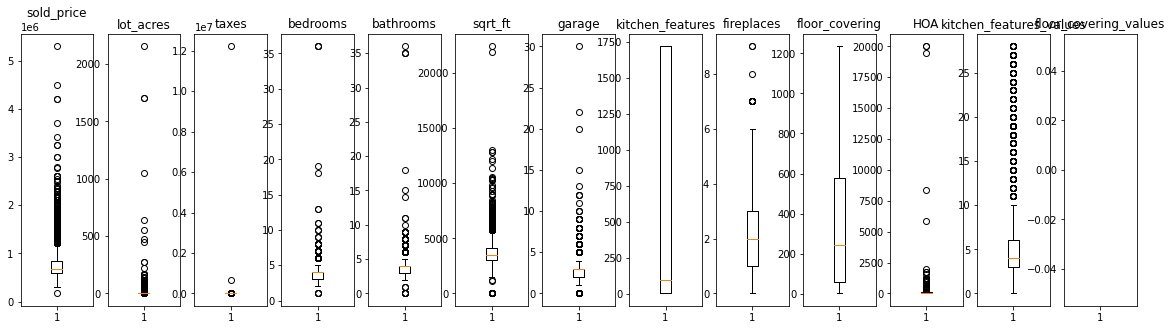

In [32]:
fig, axs = plt.subplots(ncols=len(columns_to_check), figsize=(20,5))
for i, col in enumerate(columns_to_check):
  axs[i].boxplot(data[col].values)
  axs[i].set_title(col)

plt.show()

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MLS                      5000 non-null   int64  
 1   sold_price               5000 non-null   float64
 2   zipcode                  5000 non-null   int64  
 3   longitude                5000 non-null   float64
 4   latitude                 5000 non-null   float64
 5   lot_acres                5000 non-null   float64
 6   taxes                    5000 non-null   float64
 7   year_built               5000 non-null   int64  
 8   bedrooms                 5000 non-null   int64  
 9   bathrooms                5000 non-null   int64  
 10  sqrt_ft                  5000 non-null   int64  
 11  garage                   5000 non-null   int64  
 12  kitchen_features         5000 non-null   int64  
 13  fireplaces               5000 non-null   float64
 14  floor_covering          

#Correlation Matrix

KeyError: ignored

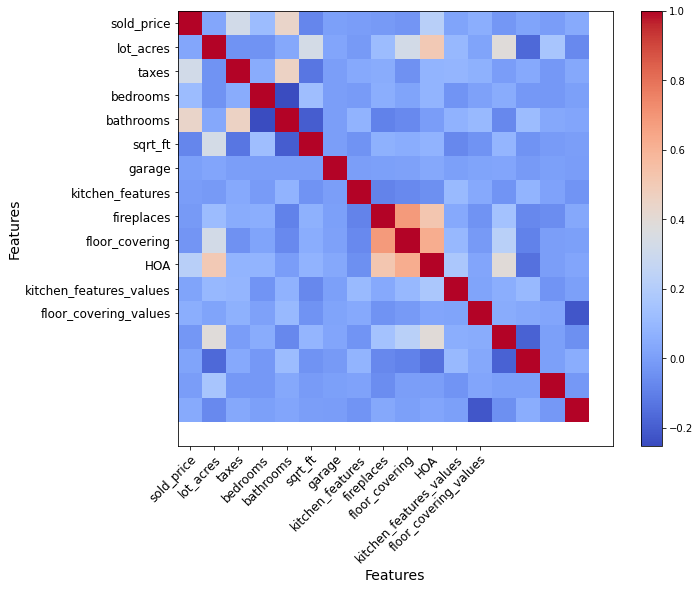

In [35]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(correlation_matrix, cmap='coolwarm')

# Display the colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the tick labels and axis labels
ax.set_xticks(np.arange(len(columns_to_check)))
ax.set_yticks(np.arange(len(columns_to_check)))
ax.set_xticklabels(columns_to_check, fontsize=12)
ax.set_yticklabels(columns_to_check, fontsize=12)
ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Features', fontsize=14)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Display the correlation values in the heatmap
for i in range(len(columns_to_check)):
    for j in range(len(columns_to_check)):
        text = ax.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                       ha="center", va="center", color="w", fontsize=10)

# Set the title of the plot
ax.set_title("Correlation Matrix", fontsize=16)

# Show the plot
plt.show()


#Check for outliers end

#Class example

In [ ]:
from geopy import Nominatim

Give it user location

In [ ]:
geolocator = Nominatim(user_agent = 'mAIstros')

variable name we are giving it

In [ ]:
location = geolocator.geocode("1785 The Exchange SE, Atlanta")

Let's look at the location

In [ ]:
location

look at the point

In [ ]:
location.point

In [ ]:
location = geolocator.geocode("10 Downing Street")

In [ ]:
location

calc location point

In [ ]:
print("Latitude: {}, Longitude: {}".format(location.point.latitude, location.point.longitude))


#Old code that is now object oriented

In [ ]:
#non_numeric = data[pd.to_numeric(data['bathrooms'], errors='coerce').isna()]
#print(non_numeric)

In [ ]:
#Replace "None" with NaN
#data['sqrt_ft'] = data['sqrt_ft'].replace("None", np.nan)

#Convert the columns to float
#data['sqrt_ft'] = data['sqrt_ft'].astype(float)

#Replace NaN with 0
#data['sqrt_ft'] = data['sqrt_ft'].fillna(0)

#Round down to the nearest integer
#data['sqrt_ft'] = data['sqrt_ft'].apply(lambda x: math.floor(x))

#Convert to int
#data['sqrt_ft'] = data['sqrt_ft'].astype(int)

In [ ]:
#Replace "None" with NaN
#data['garage'] = data['garage'].replace("None", np.nan)

#Convert the columns to float
#data['garage'] = data['garage'].astype(float)

#Replace NaN with 0
#data['garage'] = data['garage'].fillna(0)

#Round down to the nearest integer
#data['garage'] = data['garage'].apply(lambda x: math.floor(x))

#Convert to int
#data['garage'] = data['garage'].astype(int)

In [ ]:
# Replace "None" with NaN
#data['bathrooms'] = data['bathrooms'].replace("None", np.nan)

# Convert the 'bathrooms' column to float
#data['bathrooms'] = data['bathrooms'].astype(float)

# Replace NaN with 0
#data['bathrooms'] = data['bathrooms'].fillna(0)

# Round down to the nearest integer
#data['bathrooms'] = data['bathrooms'].apply(lambda x: math.floor(x))

# Convert to int
#data['bathrooms'] = data['bathrooms'].astype(int)

# Verify the result
#print(data['bathrooms'].unique())

In [ ]:
#def kitchen_features_count(features):
#    return len(features.split(','))

#data['kitchen_features'].value_counts()

# Create a new column with the counts
#data['kitchen_features_count'] = data['kitchen_features'].map(kitchen_features_count)